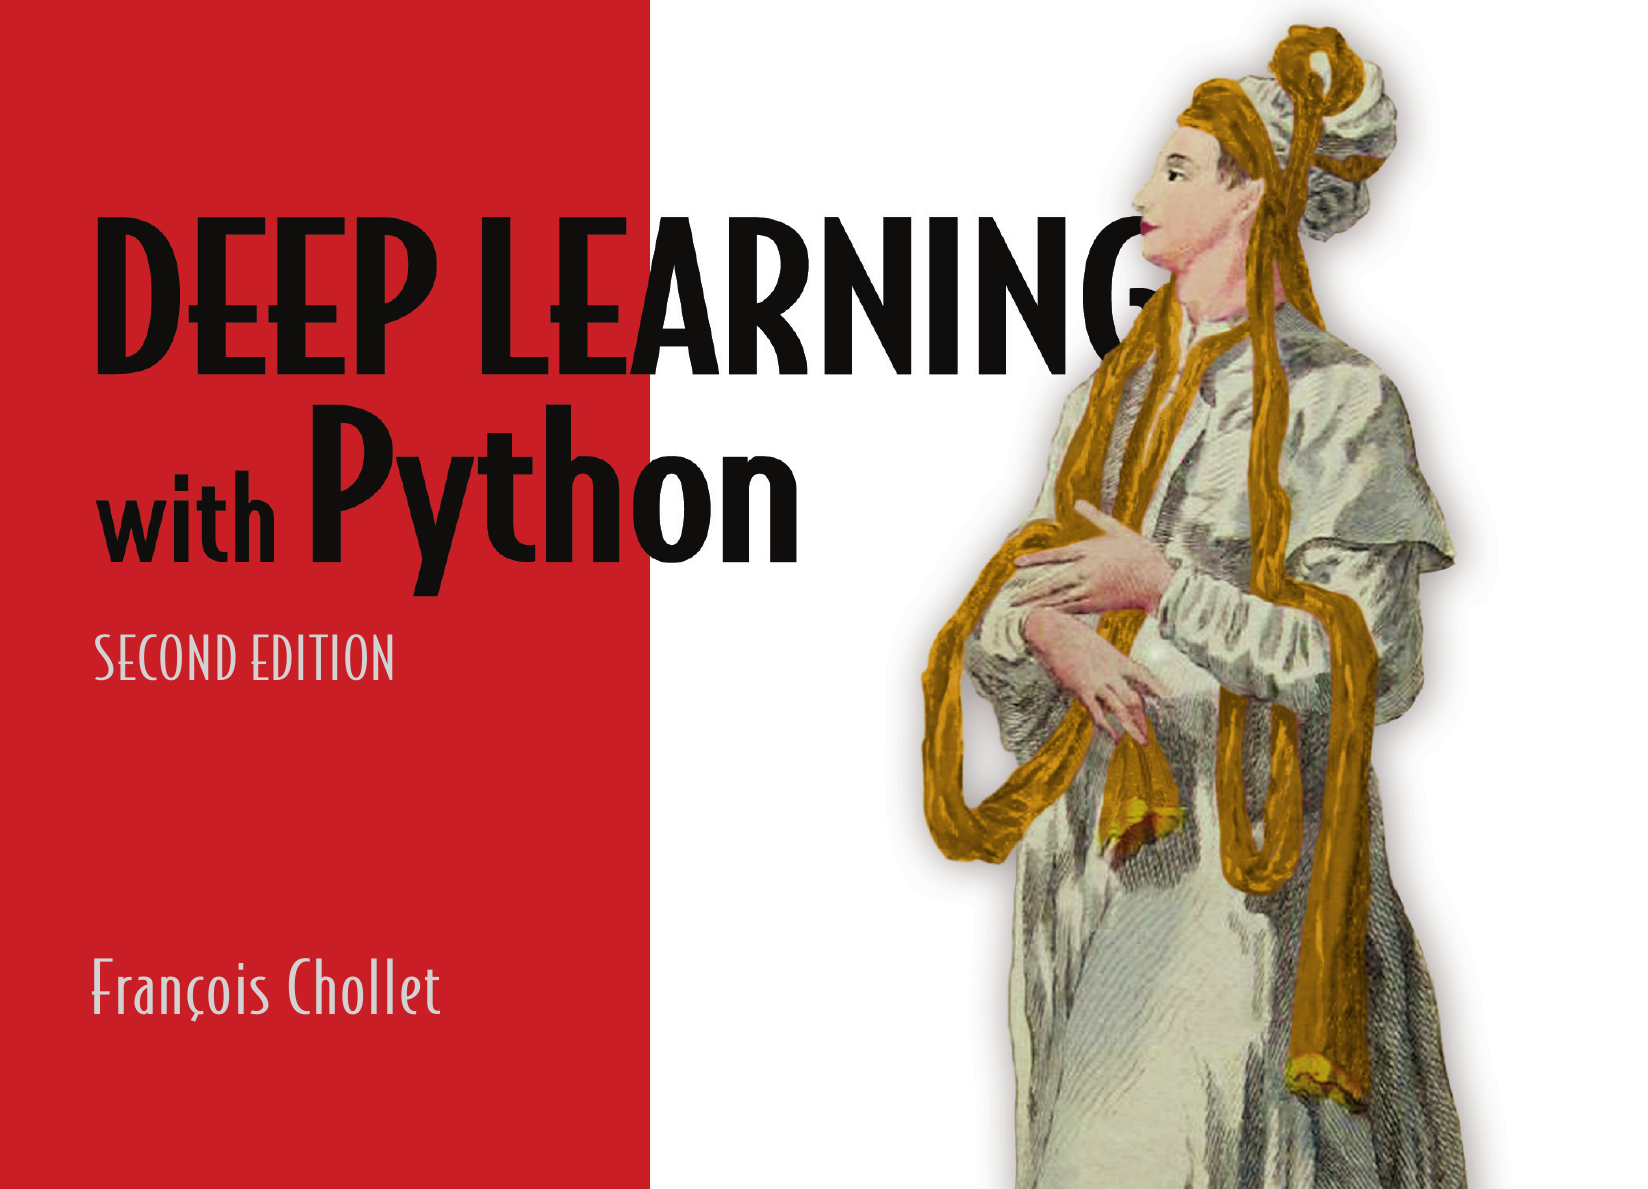

# Working with PyTorch: A deep dive

## This chapter covers
- Creating PyTorch models with the Sequential class, custom modules, and model subclassing
- Using built-in PyTorch utilities to customize training
- Using TensorBoard to monitor training and evaluation metrics
- Writing training and evaluation loops from scratch

You've now got some experience with PyTorch ―― you're familiar with the Sequential model, `Linear` layers, and built-in APIs for training, evaluation, and inference. You even learned in chapter 3 how to inherit from the Module class to create custom layers, and how to use PyTorch autograd to implement a step-by-step training loop.

In the coming chapters, we'll dig into computer vision, timeseries forecasting, natural language processing, and generative deep learning. These complex applications will require much more than a Sequential architecture and the default training loop. So let's first turn you into a PyTorch expert! In this chapter, you'll get a complete overview of the key ways to work with PyTorch APIs: everything you're going to need to handle the advanced deep learning use cases you'll encounter next.

## Requirements

* CPU:
```bash
pip install torch torchvision tensorboard
```

* GPU:
```bash
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
pip install tensorboard
```
This example installs the torch lib for CUDA 11.8, as seen in the suffix of the URL.

## A spectrum of workflows

The design of the PyTorch API is guided by the principle of progressive disclosure of complexity: make it easy to get started, yet make it possible to handle high-complexity use cases, only requiring incremental learning at each step. Simple use cases should be easy and approachable, and arbitrarily advanced workflows should be possible: no matter how niche and complex the thing you want to do, there should be a clear path to it. A path that builds upon the various things you've learned from simpler workflows. This means that you can grow from beginner to expert and still use the same tools――only in different ways.

As such, there's not a single "true" way of using PyTorch. Rather, PyTorch offers a spectrum of workflows, from the very simple to the very flexible. There are different ways to build PyTorch models, and different ways to train them, answering different needs. Because all these workflows are based on shared APIs, such as Module and nn.Module, components from any workflow can be used in any other workflow—they can all talk to each other. 

## Different ways to build PyTorch models

There are three APIs for building models in PyTorch:
- The *Sequential model*, the most approachable API—it's basically a Python list. As such, it's limited to simple stacks of layers.
- The *Custom Module*, which focuses on graph-like model architectures. It represents a nice mid-point between usability and flexibility, and as such, it's the most commonly used model-building API.
- *Module subclassing*, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won't get access to many built-in PyTorch features, and you will be more at risk of making mistakes.

### The Sequential model

The simplest way to build a PyTorch model is to use the Sequential model, which you already know about.

In [1]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(dim=1)
)

Note that it's possible to build the same model incrementally via the ``add_module()`` method, which is similar to the ``append()`` method of a Python list.


In [2]:
model = nn.Sequential()
model.add_module('linear1', nn.Linear(3, 64))
model.add_module('relu1', nn.ReLU())
model.add_module('linear2', nn.Linear(64, 10))
model.add_module('softmax', nn.Softmax(dim=1))

You saw in chapter 4 that layers only get built (which is to say, create their weights) when they are instantiated. That's because the shape of the layers' weights depends on the shape of their input: PyTorch modules initialize their parameters when the module is created with the specified input and output dimensions.

As such, the preceding Sequential model has all its weights initialized when you create it with the specified dimensions.


In [3]:
for param in model.parameters():
    print(param.shape)  # You can inspect the model's parameters immediately

torch.Size([64, 3])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


After the model is created, you can display its contents, which comes in handy for debugging.


In [4]:
# In PyTorch, you can inspect the model architecture directly
print(model)  # This shows the model structure

Sequential(
  (linear1): Linear(in_features=3, out_features=64, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


As you can see, this model happens to be named "Sequential." You can give names to everything in PyTorch—every model, every layer.


In [5]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('my_first_layer', nn.Linear(3, 64)),
    ('relu_activation', nn.ReLU()),
    ('my_last_layer', nn.Linear(64, 10)),
    ('softmax_output', nn.Softmax(dim=1))
]))
print(model)

Sequential(
  (my_first_layer): Linear(in_features=3, out_features=64, bias=True)
  (relu_activation): ReLU()
  (my_last_layer): Linear(in_features=64, out_features=10, bias=True)
  (softmax_output): Softmax(dim=1)
)


When building a Sequential model incrementally, it's useful to be able to print a summary of what the current model looks like after you add each layer. In PyTorch, you can print the model structure at any time since parameters are initialized upon creation.


In [6]:
model = nn.Sequential()
model.add_module('input_layer', nn.Linear(3, 64))
print(model)  # You can print the structure immediately
model.add_module('relu', nn.ReLU())
print(model)  # And see how it grows as you add layers

Sequential(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
)
Sequential(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
)


Now you can print the model structure to follow how your model changes as you add more layers:


In [7]:
print(model)

Sequential(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
)


In [8]:
model.add_module('output_layer', nn.Linear(64, 10))
model.add_module('softmax', nn.Softmax(dim=1))
print(model)

Sequential(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


This is a pretty common debugging workflow when dealing with layers that transform their inputs in complex ways, such as the convolutional layers you'll learn about in chapter 8.


### Custom Modules

The Sequential model is easy to use, but its applicability is extremely limited: it can only express models with a single input and a single output, applying one layer after the other in a sequential fashion. In practice, it's pretty common to encounter models with multiple inputs (say, an image and its metadata), multiple outputs (different things you want to predict about the data), or a nonlinear topology.

In such cases, you'd build your model using custom nn.Module subclassing. This is what most PyTorch models you'll encounter in the wild use. It's fun and powerful—it feels like playing with LEGO bricks.

#### A SIMPLE EXAMPLE
Let's start with something simple: the stack of two layers we used in the previous section. Its custom module version looks like the following listing.

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=10):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

model = SimpleModel()

Let's go over this step by step.

We started by defining a class that inherits from ``nn.Module`` (note that you can also give names to these input objects, like everything else):

```python
class SimpleModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=10):
        super(SimpleModel, self).__init__()
```

This class holds information about the layers and their configurations that the model will use:


In [10]:
# You can inspect the model structure
print(model)

SimpleModel(
  (linear1): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [11]:
# You can also check the data types of parameters
for param in model.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


We call such an object a *module*. It contains the actual parameters and defines the forward computation graph. It encodes the specifications of the actual operations that the model will perform when you use it.

Next, we defined the forward method that specifies how data flows through the layers:

```python
def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.softmax(x)
    return x
```

All PyTorch modules can be called both on real tensors of data. When called, they execute the forward method and return the computed outputs:


In [12]:
# Test with dummy input
dummy_input = torch.randn(1, 3)
output = model(dummy_input)
print(output.shape)

torch.Size([1, 10])


After creating the model, you can inspect its structure. Here's the structure of our model:


In [13]:
print(model)

SimpleModel(
  (linear1): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


#### MULTI-INPUT, MULTI-OUTPUT MODELS
Unlike this toy model, most deep learning models don't look like lists—they look like graphs. They may, for instance, have multiple inputs or multiple outputs. It's for this kind of model that custom modules really shine.

Let's say you're building a system to rank customer support tickets by priority and route them to the appropriate department. Your model has three inputs:

- The title of the ticket (text input)
- The text body of the ticket (text input)
- Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size ``vocabulary_size`` (see chapter 11 for detailed information about text encoding techniques).

Your model also has two outputs:

- The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
- The department that should handle the ticket (a softmax over the set of departments)

You can build this model in a few lines with a custom module.

In [14]:
class TicketClassifier(nn.Module):
    def __init__(self, vocabulary_size=10000, num_tags=100, num_departments=4):
        super(TicketClassifier, self).__init__()
        
        # Calculate total input size
        total_input_size = vocabulary_size + vocabulary_size + num_tags
        
        self.feature_layer = nn.Linear(total_input_size, 64)
        self.relu = nn.ReLU()
        self.priority_head = nn.Linear(64, 1)
        self.department_head = nn.Linear(64, num_departments)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, title, text_body, tags):
        # Concatenate all inputs
        features = torch.cat([title, text_body, tags], dim=1)
        features = self.feature_layer(features)
        features = self.relu(features)
        
        priority = self.priority_head(features)
        priority = self.sigmoid(priority)
        
        department = self.department_head(features)
        department = self.softmax(department)
        
        return priority, department

vocabulary_size = 10000 
num_tags = 100 
num_departments = 4 

model = TicketClassifier(vocabulary_size, num_tags, num_departments)

Custom modules provide a simple, LEGO-like, yet very flexible way to define arbitrary graphs of layers like these. 


#### TRAINING A MULTI-INPUT, MULTI-OUTPUT MODEL

You can train your model in much the same way as you would train a Sequential model, by setting up a training loop with your input and output data. The data should be prepared according to how your forward method expects them.


In [15]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
 
num_samples = 1280 
 
title_data = torch.randint(0, 2, size=(num_samples, vocabulary_size), dtype=torch.float32)
text_body_data = torch.randint(0, 2, size=(num_samples, vocabulary_size), dtype=torch.float32)
tags_data = torch.randint(0, 2, size=(num_samples, num_tags), dtype=torch.float32)

priority_data = torch.rand(size=(num_samples, 1))
department_data = torch.randint(0, 2, size=(num_samples, num_departments), dtype=torch.float32)

# Setup optimizer and loss functions
optimizer = optim.RMSprop(model.parameters())
priority_loss_fn = nn.MSELoss()
department_loss_fn = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(1):
    optimizer.zero_grad()
    
    priority_pred, department_pred = model(title_data, text_body_data, tags_data)
    
    priority_loss = priority_loss_fn(priority_pred, priority_data)
    department_loss = department_loss_fn(department_pred, department_data)
    
    total_loss = priority_loss + department_loss
    total_loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    priority_preds, department_preds = model(title_data, text_body_data, tags_data)

If you want to organize your data better, you can also use a dictionary-based approach with custom data handling.


In [16]:
# Alternative approach using dictionaries for better organization
def train_step(model, inputs, targets, optimizer, priority_loss_fn, department_loss_fn):
    model.train()
    optimizer.zero_grad()
    
    priority_pred, department_pred = model(
        inputs["title"], inputs["text_body"], inputs["tags"]
    )
    
    priority_loss = priority_loss_fn(priority_pred, targets["priority"])
    department_loss = department_loss_fn(department_pred, targets["department"])
    
    total_loss = priority_loss + department_loss
    total_loss.backward()
    optimizer.step()
    
    return {
        "priority_loss": priority_loss.item(),
        "department_loss": department_loss.item(),
        "total_loss": total_loss.item()
    }

inputs = {
    "title": title_data, 
    "text_body": text_body_data,
    "tags": tags_data
}
targets = {
    "priority": priority_data, 
    "department": department_data
}

losses = train_step(model, inputs, targets, optimizer, priority_loss_fn, department_loss_fn)
print(f"Losses: {losses}")

Losses: {'priority_loss': 0.34146687388420105, 'department_loss': 2.956566333770752, 'total_loss': 3.2980332374572754}


#### THE POWER OF CUSTOM MODULES: ACCESS TO LAYER CONNECTIVITY
A custom module is an explicit computational graph. This makes it possible to inspect how layers are connected and reuse intermediate features from other models. It also nicely fits the "mental model" that most researchers use when thinking about a deep neural network: a graph of operations. This enables two important use cases: model visualization and feature extraction.

Let's visualize the connectivity of the model we just defined (the *topology* of the model). You can inspect a PyTorch model structure easily.

In [17]:
print(model)

TicketClassifier(
  (feature_layer): Linear(in_features=20100, out_features=64, bias=True)
  (relu): ReLU()
  (priority_head): Linear(in_features=64, out_features=1, bias=True)
  (department_head): Linear(in_features=64, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


You can add more detailed information about the model parameters and structure:


In [18]:
def print_model_info(model):
    print("Model Structure:")
    print(model)
    print("\nModel Parameters:")
    total_params = 0
    for name, param in model.named_parameters():
        print(f"{name}: {param.shape}")
        total_params += param.numel()
    print(f"\nTotal parameters: {total_params}")

print_model_info(model)

Model Structure:
TicketClassifier(
  (feature_layer): Linear(in_features=20100, out_features=64, bias=True)
  (relu): ReLU()
  (priority_head): Linear(in_features=64, out_features=1, bias=True)
  (department_head): Linear(in_features=64, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

Model Parameters:
feature_layer.weight: torch.Size([64, 20100])
feature_layer.bias: torch.Size([64])
priority_head.weight: torch.Size([1, 64])
priority_head.bias: torch.Size([1])
department_head.weight: torch.Size([4, 64])
department_head.bias: torch.Size([4])

Total parameters: 1286789


Access to layer connectivity also means that you can inspect and reuse individual modules and their outputs. The model's named modules provide access to each component:


In [19]:
for name, module in model.named_modules():
    print(f"{name}: {module}")

: TicketClassifier(
  (feature_layer): Linear(in_features=20100, out_features=64, bias=True)
  (relu): ReLU()
  (priority_head): Linear(in_features=64, out_features=1, bias=True)
  (department_head): Linear(in_features=64, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
feature_layer: Linear(in_features=20100, out_features=64, bias=True)
relu: ReLU()
priority_head: Linear(in_features=64, out_features=1, bias=True)
department_head: Linear(in_features=64, out_features=4, bias=True)
sigmoid: Sigmoid()
softmax: Softmax(dim=1)


In [20]:
# Access specific layers
print("Feature layer:", model.feature_layer)
print("Priority head:", model.priority_head)

Feature layer: Linear(in_features=20100, out_features=64, bias=True)
Priority head: Linear(in_features=64, out_features=1, bias=True)


This enables you to do *feature extraction*, creating models that reuse intermediate features from another model.

Let's say you want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. You could do this via a classification layer over three categories: "quick", "medium", and "difficult". You don't need to recreate and retrain a model from scratch. You can start from the intermediate features of your previous model, since you have access to them, like this.

In [21]:
class ExtendedTicketClassifier(nn.Module):
    def __init__(self, base_model, num_difficulty_classes=3):
        super(ExtendedTicketClassifier, self).__init__()
        
        # Reuse the feature extraction part of the base model
        self.feature_layer = base_model.feature_layer
        self.relu = base_model.relu
        self.priority_head = base_model.priority_head
        self.department_head = base_model.department_head
        self.sigmoid = base_model.sigmoid
        self.softmax = base_model.softmax
        
        # Add new difficulty classification head
        self.difficulty_head = nn.Linear(64, num_difficulty_classes)
        self.difficulty_softmax = nn.Softmax(dim=1)
    
    def forward(self, title, text_body, tags):
        # Concatenate all inputs
        features = torch.cat([title, text_body, tags], dim=1)
        features = self.feature_layer(features)
        features = self.relu(features)
        
        priority = self.priority_head(features)
        priority = self.sigmoid(priority)
        
        department = self.department_head(features)
        department = self.softmax(department)
        
        difficulty = self.difficulty_head(features)
        difficulty = self.difficulty_softmax(difficulty)
        
        return priority, department, difficulty

new_model = ExtendedTicketClassifier(model)

Let's inspect our new model:


In [22]:
print_model_info(new_model)


Model Structure:
ExtendedTicketClassifier(
  (feature_layer): Linear(in_features=20100, out_features=64, bias=True)
  (relu): ReLU()
  (priority_head): Linear(in_features=64, out_features=1, bias=True)
  (department_head): Linear(in_features=64, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (difficulty_head): Linear(in_features=64, out_features=3, bias=True)
  (difficulty_softmax): Softmax(dim=1)
)

Model Parameters:
feature_layer.weight: torch.Size([64, 20100])
feature_layer.bias: torch.Size([64])
priority_head.weight: torch.Size([1, 64])
priority_head.bias: torch.Size([1])
department_head.weight: torch.Size([4, 64])
department_head.bias: torch.Size([4])
difficulty_head.weight: torch.Size([3, 64])
difficulty_head.bias: torch.Size([3])

Total parameters: 1286984


### Subclassing the Module class

The last model-building pattern you should know about is the most advanced one: custom ``Module`` subclassing. You learned in chapter 3 how to subclass the ``Module`` class to create custom layers. Building full models with Module subclassing is pretty similar:

- In the ``__init__()`` method, define the layers the model will use.
- In the ``forward()`` method, define the forward pass of the model, reusing the layers previously created.
- Instantiate your subclass, and call it on data to create its outputs.


#### REWRITING OUR PREVIOUS EXAMPLE AS A SUBCLASSED MODEL

Let's take a look at a simple example: we will reimplement the customer support ticket management model using a ``Module`` subclass.

In [23]:
class CustomerTicketModel(nn.Module):
    def __init__(self, vocabulary_size=10000, num_tags=100, num_departments=4):
        super(CustomerTicketModel, self).__init__()
        
        total_input_size = vocabulary_size + vocabulary_size + num_tags
        self.concat_layer = None  # We'll concatenate manually in forward
        self.mixing_layer = nn.Linear(total_input_size, 64)
        self.relu = nn.ReLU()
        self.priority_scorer = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.department_classifier = nn.Linear(64, num_departments)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        
        features = torch.cat([title, text_body, tags], dim=1)
        features = self.mixing_layer(features)
        features = self.relu(features)
        
        priority = self.priority_scorer(features)
        priority = self.sigmoid(priority)
        
        department = self.department_classifier(features)
        department = self.softmax(department)
        
        return priority, department

Once you've defined the model, you can instantiate it. Note that it will create its weights immediately when you instantiate it, much like other ``Module`` subclasses:


In [24]:
model = CustomerTicketModel(vocabulary_size=vocabulary_size, num_tags=num_tags, 
                           num_departments=num_departments)

priority, department = model({
    "title": title_data, "text_body": text_body_data, "tags": tags_data
})

So far, everything looks very similar to the custom module approach you encountered earlier. What, then, is the difference between a simple custom module and a more complex Module subclass? It's mainly about organization and complexity: a "module" is a building block you use to create models, and a "model" is often a more complex composition of modules that you will actually train, export for inference, etc. In short, PyTorch treats all nn.Module subclasses equally—they all have the same capabilities for training, evaluation, and state management.

You can train a ``Module`` subclass just like a Sequential or custom module:

In [25]:
optimizer = optim.RMSprop(model.parameters())
priority_loss_fn = nn.MSELoss()
department_loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(1):
    optimizer.zero_grad()
    
    inputs = {
        "title": title_data,
        "text_body": text_body_data,
        "tags": tags_data
    }
    priority_pred, department_pred = model(inputs)
    
    priority_loss = priority_loss_fn(priority_pred, priority_data)
    department_loss = department_loss_fn(department_pred, department_data)
    
    total_loss = priority_loss + department_loss
    total_loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    priority_preds, department_preds = model(inputs)
    print(f"Priority predictions shape: {priority_preds.shape}")
    print(f"Department predictions shape: {department_preds.shape}")

Priority predictions shape: torch.Size([1280, 1])
Department predictions shape: torch.Size([1280, 4])


The ``Module`` subclassing workflow is the most flexible way to build a model. It enables you to build models that cannot be expressed as simple directed acyclic graphs of layers—imagine, for instance, a model where the ``forward()`` method uses layers inside a ``for`` loop, or even calls them recursively. Anything is possible—you're in charge.


#### BEWARE: WHAT SUBCLASSED MODELS DON'T SUPPORT

This freedom comes at a cost: with heavily subclassed models, you are responsible for more of the model logic, which means your potential error surface is much larger. As a result, you will have more debugging work to do. You are developing a new Python object, not just snapping together LEGO bricks.

Custom modules and heavily subclassed models are also substantially different in nature. A simple custom module is an explicit data structure—a composition of layers, which you can view, inspect, and modify easily. A complex subclassed model is a piece of code—a Python class with a ``forward()`` method that contains raw computational logic. This is the source of the subclassing workflow's flexibility—you can code up whatever functionality you like—but it introduces new limitations.

For instance, because the way layers are connected to each other can be hidden inside the body of the ``forward()`` method, complex control flow can make inspection more difficult. However, PyTorch still provides tools to inspect the model structure and you can always print the model to see its components. The main difference is that very complex forward methods with conditional logic become harder to visualize as simple graphs.

### Mixing and matching different components

Crucially, choosing one of these patterns—the Sequential model, custom modules, or ``Module`` subclassing—does not lock you out of the others. All models in the PyTorch API can smoothly interoperate with each other, whether they're Sequential models, custom modules, or subclassed models written from scratch. They're all part of the same spectrum of workflows.

For instance, you can use a subclassed module in a larger model.

In [26]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(Classifier, self).__init__()
        if num_classes == 2:
            num_units = 1
            self.activation = nn.Sigmoid()
        else:
            num_units = num_classes
            self.activation = nn.Softmax(dim=1)
        self.dense = nn.Linear(input_size, num_units)

    def forward(self, inputs):
        x = self.dense(inputs)
        return self.activation(x)

class CombinedModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_classes=10):
        super(CombinedModel, self).__init__()
        self.features = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.classifier = Classifier(hidden_size, num_classes)
    
    def forward(self, x):
        features = self.features(x)
        features = self.relu(features)
        outputs = self.classifier(features)
        return outputs

model = CombinedModel()

Inversely, you can use a Sequential model as part of a subclassed module.


In [27]:
binary_classifier = nn.Sequential(
    nn.Linear(64, 1),
    nn.Sigmoid()
)

class MyModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64):
        super(MyModel, self).__init__()
        self.features = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.classifier = binary_classifier

    def forward(self, inputs):
        features = self.features(inputs)
        features = self.relu(features)
        return self.classifier(features)

model = MyModel()

### Remember: Use the right tool for the job

You've learned about the spectrum of workflows for building PyTorch models, from the simplest workflow, the Sequential model, to the most advanced one, model subclassing. When should you use one over the other? Each one has its pros and cons—pick the one most suitable for the job at hand.

In general, custom modules provide you with a pretty good trade-off between ease of use and flexibility. They also give you direct access to layer connectivity, which is very powerful for use cases such as model inspection or feature extraction. If you can use custom modules—that is, if your model can be expressed as a clear composition of layers—I recommend using them over complex subclassing.

Going forward, all examples in this book will use custom modules, simply because all the models we will work with are expressible as compositions of layers. We will, however, make frequent use of subclassed layers. In general, using custom modules that include subclassed layers provides the best of both worlds: high development flexibility while retaining the advantages of clear model structure.

## Using built-in training and evaluation loops

The principle of progressive disclosure of complexity—access to a spectrum of workflows that go from dead easy to arbitrarily flexible, one step at a time—also applies to model training. PyTorch provides you with different workflows for training models. They can be as simple as writing a basic training loop, or as advanced as writing a new training algorithm from scratch.

You are already familiar with the basic training workflow using optimizers and loss functions. As a reminder, take a look at the following listing.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

def get_mnist_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)
    )
    return model

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [05:02<00:00, 32.7kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 208kB/s]
100%|██████████| 1.65M/1.65M [00:22<00:00, 72.1kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.15MB/s]


In [29]:
model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
epochs = 3
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_dataset)
    print(f'Epoch {epoch}: Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Test evaluation
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100.0 * correct / len(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 0: Val Loss: 0.3120, Accuracy: 92.37%
Epoch 1: Val Loss: 0.3266, Accuracy: 92.33%
Epoch 2: Val Loss: 0.2301, Accuracy: 95.28%
Test Loss: 0.2208, Test Accuracy: 95.26%


There are a couple of ways you can customize this simple workflow:
- Create your own custom metrics.
- Use utilities to schedule actions to be taken at specific points during training.

Let's take a look at these.

### Writing your own metrics

Metrics are key to measuring the performance of your model—in particular, to measuring the difference between its performance on the training data and its performance on the test data. You can easily implement commonly used metrics for classification and regression, and most of the time that's what you will use. But if you're doing anything out of the ordinary, you will need to be able to write your own metrics. It's simple!

A PyTorch metric can be a simple class that maintains internal state. Unlike layers, these variables aren't updated via backpropagation, so you have to write the state-update logic yourself.

For example, here's a simple custom metric that measures the root mean squared error (RMSE).

In [30]:
import torch
import torch.nn.functional as F

class RootMeanSquaredError:
    def __init__(self, name="rmse"):
        self.name = name
        self.reset()
        
    def reset(self):
        self.mse_sum = 0.0
        self.total_samples = 0
        
    def update(self, y_true, y_pred):
        # Convert to one-hot if needed for classification
        if y_true.dim() == 1 and y_pred.dim() == 2:
            y_true = F.one_hot(y_true, num_classes=y_pred.shape[1]).float()
        
        mse = torch.sum((y_true - y_pred) ** 2)
        self.mse_sum += mse.item()
        self.total_samples += y_pred.shape[0]
    
    def compute(self):
        if self.total_samples == 0:
            return 0.0
        return (self.mse_sum / self.total_samples) ** 0.5

You use the ``compute()`` method to return the current value of the metric:


```python
def result(self):
    return self.compute()
```

Meanwhile, you also need to expose a way to reset the metric state without having to reinstantiate it—this enables the same metric objects to be used across different epochs of training or across both training and evaluation. You do this with the ``reset()`` method:


```python
def reset_state(self):
    self.reset()
```

Custom metrics can be used just like built-in ones. Let's test-drive our own metric:


In [31]:
model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()
rmse_metric = RootMeanSquaredError()

# Training with custom metric
model.train()
epochs = 3
for epoch in range(epochs):
    rmse_metric.reset()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Update custom metric
        rmse_metric.update(target, output)
    
    print(f'Epoch {epoch}: RMSE: {rmse_metric.compute():.4f}')

Epoch 0: RMSE: 97.7571
Epoch 1: RMSE: 52.4808
Epoch 2: RMSE: 99.7942


You can now see the training progress displaying the RMSE of your model.


### Using training utilities


Launching a training run on a large dataset for tens of epochs can be a bit like launching a paper airplane: past the initial impulse, you don't have any control over its trajectory or its landing spot. If you want to avoid bad outcomes (and thus wasted paper airplanes), it's smarter to use utilities that can help you control and monitor the training process.

PyTorch doesn't have built-in callbacks like Keras, but you can easily implement similar functionality using Python classes and functions. These utilities can help you monitor the model during training and automatically take actions based on the current state.

Here are some examples of ways you can use training utilities:

- **Model checkpointing**—Saving the current state of the model at different points during training.
- **Early stopping**—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- **Dynamically adjusting the value of certain parameters during training**—Such as the learning rate of the optimizer.
- **Logging training and validation metrics during training, or visualizing the representations learned by the model as they're updated**.

Let's implement some of these utilities:

In [32]:
import os
import numpy as np

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best_value = None
        
    def __call__(self, current_value, model):
        if not self.save_best_only:
            torch.save(model.state_dict(), self.filepath)
        else:
            if self.best_value is None or current_value < self.best_value:
                self.best_value = current_value
                torch.save(model.state_dict(), self.filepath)
                print(f"Model saved to {self.filepath}")

Let's review how to use them: ``EarlyStopping`` and ``ModelCheckpoint``.


#### THE EARLYSTOPPING AND MODELCHECKPOINT UTILITIES


When you're training a model, there are many things you can't predict from the start. In particular, you can't tell how many epochs will be needed to get to an optimal validation loss. Our examples so far have adopted the strategy of training for a fixed number of epochs. Of course, this approach can be wasteful. A much better way to handle this is to stop training when you measure that the validation loss is no longer improving. This can be achieved using the ``EarlyStopping`` utility.

The ``EarlyStopping`` utility interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this utility allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs. This utility is typically used in combination with ``ModelCheckpoint``, which lets you continually save the model during training (and, optionally, save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch).


In [33]:
early_stopping = EarlyStopping(patience=2)
checkpoint = ModelCheckpoint("best_model.pth", monitor='val_loss', save_best_only=True)

model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_dataset)
    print(f'Epoch {epoch}: Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Check early stopping and save checkpoint
    checkpoint(val_loss, model)
    if early_stopping(val_loss, model):
        print(f"Early stopping at epoch {epoch}")
        break

Epoch 0: Val Loss: 0.3301, Accuracy: 92.04%
Model saved to best_model.pth
Epoch 1: Val Loss: 0.3712, Accuracy: 91.93%
Epoch 2: Val Loss: 0.3183, Accuracy: 92.87%
Model saved to best_model.pth
Epoch 3: Val Loss: 0.4025, Accuracy: 91.47%
Epoch 4: Val Loss: 0.3587, Accuracy: 92.71%
Early stopping at epoch 4


Note that you can always save models manually after training as well—just call

``torch.save(model.state_dict(), 'my_checkpoint_path.pth')``. To reload the model you've saved, just use


In [34]:
model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

### Writing your own training utilities


If you need to take a specific action during training that isn't covered by the utilities above, you can write your own training utilities. Utilities are implemented as Python classes with specific methods that get called at various points during training.

Here's a simple example that saves a list of per-batch loss values during training and saves a graph of these values at the end of each epoch.

In [35]:
import matplotlib.pyplot as plt

class LossHistory:
    def __init__(self):
        self.per_batch_losses = []

    def on_train_begin(self):
        self.per_batch_losses = []

    def on_batch_end(self, loss):
        self.per_batch_losses.append(loss)

    def on_epoch_end(self, epoch):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Let's test-drive it:


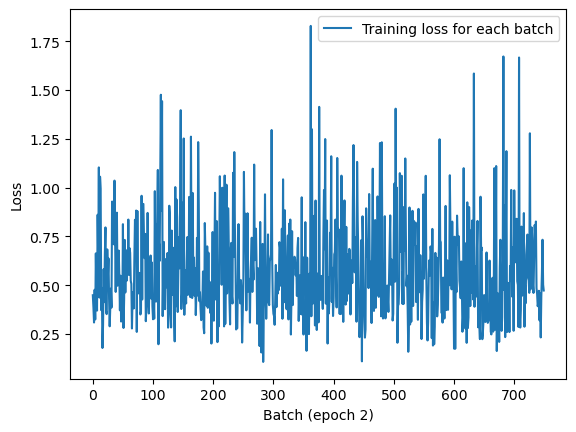

In [36]:
model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()
loss_history = LossHistory()

loss_history.on_train_begin()

for epoch in range(3):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        loss_history.on_batch_end(loss.item())
    
    loss_history.on_epoch_end(epoch)

> Figure 7.1  The output of our custom history plotting callback

We get plots that look like figure 7.1 (above).


### Monitoring and visualization with TensorBoard


To do good research or develop good models, you need rich, frequent feedback about what's going on inside your models during your experiments. That's the point of running experiments: to get information about how well a model performs—as much information as possible. Making progress is an iterative process, a loop—you start with an idea and express it as an experiment, attempting to validate or invalidate your idea.

You run this experiment and process the information it generates. This inspires your next idea. The more iterations of this loop you're able to run, the more refined and powerful your ideas become. PyTorch helps you go from idea to experiment in the least possible time, and fast GPUs can help you get from experiment to result as quickly as possible. But what about processing the experiment's results? That's where TensorBoard comes in (see figure 7.2).

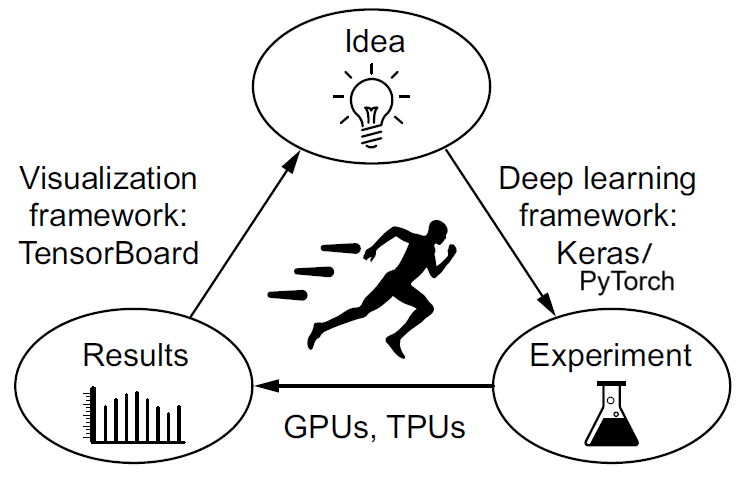

Figure 7.2     The loop of progress.

Inspired by the original work, **Deep Learning with Python, second edition** (2021) by Francois Chollet and Matthew Watson.

TensorBoard is a browser-based application that you can run locally. It's the best way to monitor everything that goes on inside your model during training. With TensorBoard, you can
- Visually monitor metrics during training
- Visualize your model architecture
- Visualize histograms of activations and gradients
- Explore embeddings in 3D

If you're monitoring more information than just the model's final loss, you can develop a clearer vision of what the model does and doesn't do, and you can make progress more quickly.

The easiest way to use TensorBoard with a PyTorch model is to use the ``torch.utils.tensorboard.SummaryWriter`` class.

In the simplest case, just specify where you want the writer to save logs, and you're good to go:

Note that the ``tensorboard`` executable should be already available if you have installed TensorBoard via pip; if not, you can install TensorBoard manually via

``pip install tensorboard``

In [46]:
from torch.utils.tensorboard import SummaryWriter

model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

writer = SummaryWriter(log_dir="full_path_to_your_log_dir")

for epoch in range(3):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Log to TensorBoard every 100 batches
        if batch_idx % 100 == 0:
            writer.add_scalar('Training/Loss', loss.item(), epoch * len(train_loader) + batch_idx)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_dataset)
    
    # Log validation metrics
    writer.add_scalar('Validation/Loss', val_loss, epoch)
    writer.add_scalar('Validation/Accuracy', accuracy, epoch)
    
    print(f'Epoch {epoch}: Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

writer.close()

Epoch 0: Val Loss: 0.3081, Accuracy: 92.12%
Epoch 1: Val Loss: 0.2997, Accuracy: 92.71%
Epoch 2: Val Loss: 0.2824, Accuracy: 93.85%


Once the model starts running, it will write logs at the target location. If you are running your Python script on a local machine, you can then launch the local TensorBoard server using the following command:

```bash
tensorboard --logdir /full_path_to_your_log_dir
```

You can then navigate to the URL that the command returns in order to access the TensorBoard interface.

If you are running your script in a Jupyter notebook, you can run an embedded TensorBoard instance as part of your notebook, using the following commands:

```python
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir
```

In the TensorBoard interface, you will be able to monitor live graphs of your training and evaluation metrics (see figure 7.3).


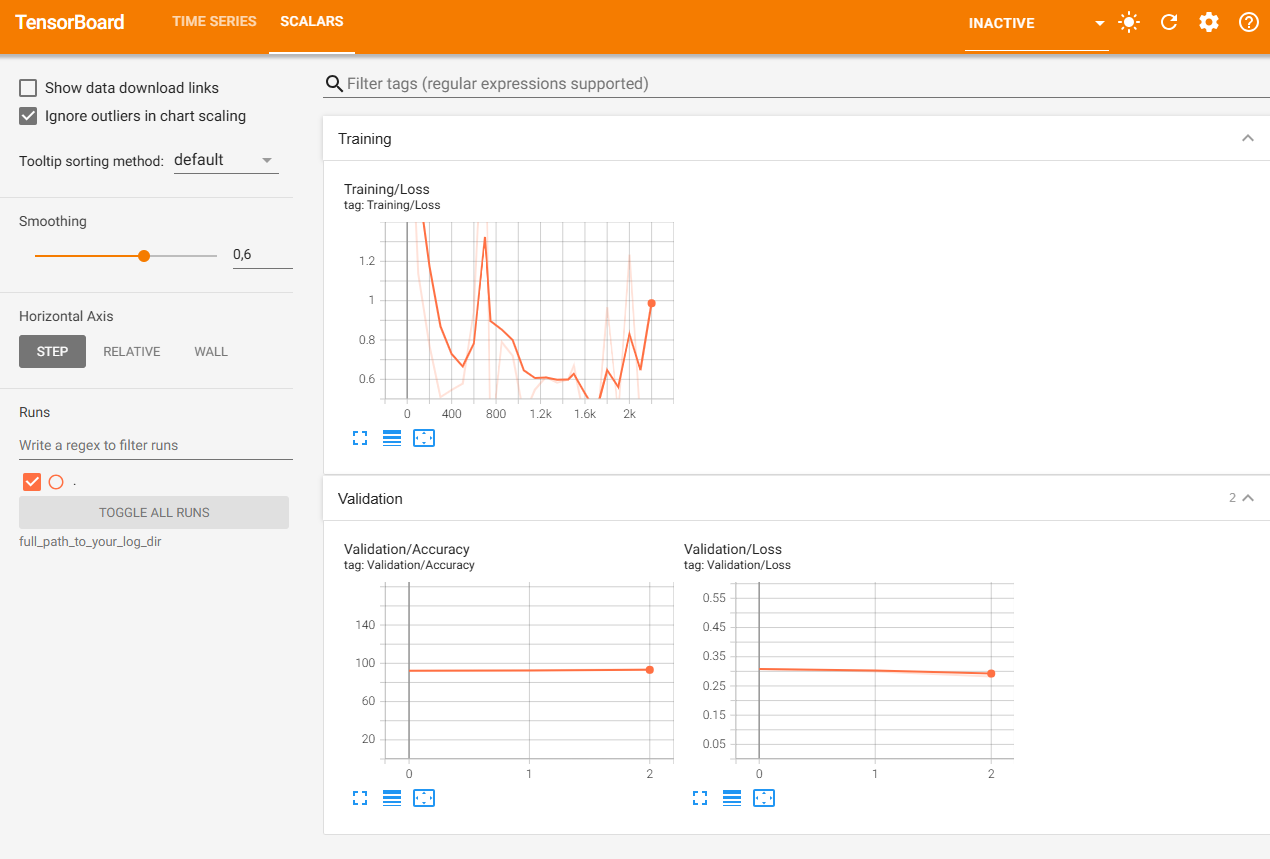

Figure 7.3 - TensorBoard can be used for easy monitoring of training and evaluation metrics.


## Writing your own training and evaluation loops


The basic training workflow strikes a nice balance between ease of use and flexibility. It's what you will use most of the time. However, it isn't meant to support everything a deep learning researcher may want to do, even with custom metrics, custom losses, and custom training utilities.

After all, the basic training workflow is solely focused on supervised learning: a setup where there are known *targets* (also called labels or annotations) associated with your input data, and where you compute your loss as a function of these targets and the model's predictions. However, not every form of machine learning falls into this category. There are other setups where no explicit targets are present, such as *generative learning* (which we will discuss in chapter 12), *self-supervised learning* (where targets are obtained from the inputs), and *reinforcement learning* (where learning is driven by occasional "rewards," much like training a dog). Even if you're doing regular supervised learning, as a researcher, you may want to add some novel bells and whistles that require low-level flexibility.

Whenever you find yourself in a situation where the basic training workflow is not enough, you will need to write your own custom training logic. You already saw simple examples of low-level training loops in chapters 2 and 3. As a reminder, the contents of a typical training loop look like this:

1. Run the forward pass (compute the model's output) to obtain a loss value for the current batch of data.
2. Retrieve the gradients of the loss with regard to the model's weights.
3. Update the model's weights so as to lower the loss value on the current batch of data.

These steps are repeated for as many batches as necessary. This is essentially what the basic training workflow does. In this section, you will learn to implement comprehensive training and evaluation loops from scratch, which will give you all the knowledge you need to write any training algorithm you may come up with.

Let's go over the details.

### Training versus inference


In the low-level training loop examples you've seen so far, step 1 (the forward pass) was done via ``outputs = model(inputs)``, and step 2 (retrieving the gradients) was done via ``loss.backward()``. In the general case, there are actually two subtleties you need to take into account.

Some PyTorch layers, such as the ``Dropout`` layer, have different behaviors during training and during inference (when you use them to generate predictions). Such layers automatically adjust their behavior based on the model's training mode. Calling ``model.train()`` puts the model in training mode, while calling ``model.eval()`` puts it in evaluation mode. Remember to set the appropriate mode when you use a PyTorch model! Our forward pass thus becomes context-aware:

```python
# For training
model.train()
outputs = model(inputs)

# For inference
model.eval()
with torch.no_grad():
    outputs = model(inputs)
```

In addition, note that when you retrieve the gradients of the weights of your model, PyTorch automatically computes gradients for all parameters that have ``requires_grad=True``. By default, all model parameters have ``requires_grad=True``. You can access these parameters via ``model.parameters()``:

- **Trainable parameters**—These are meant to be updated via backpropagation to minimize the loss of the model, such as the weight and bias of a ``Linear`` layer.
- **Non-trainable parameters**—These can be made by setting ``requires_grad=False``, and are meant to be updated during the forward pass by the layers that own them, or remain fixed.

Among PyTorch built-in layers, the ``BatchNorm`` layers feature parameters that track running statistics (moving averages) which are not updated via backpropagation. These are automatically handled by the layer's training/eval mode.

Taking into account these two details, a supervised-learning training step ends up looking like this:

```python
def train_step(model, inputs, targets, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(targets, outputs)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()
```

### Low-level usage of metrics


In a low-level training loop, you will probably want to leverage custom metrics (whether custom ones or simple built-in calculations). You've already learned how to create metrics: simply create a class that tracks state and can be updated with new predictions and targets:


In [38]:
class Accuracy:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.correct = 0
        self.total = 0
    
    def update(self, targets, predictions):
        pred = predictions.argmax(dim=1)
        self.correct += pred.eq(targets).sum().item()
        self.total += targets.size(0)
    
    def compute(self):
        if self.total == 0:
            return 0.0
        return 100.0 * self.correct / self.total

targets = torch.tensor([0, 1, 2])
predictions = torch.tensor([[0.9, 0.1, 0.0], [0.1, 0.8, 0.1], [0.0, 0.1, 0.9]])
accuracy = Accuracy()
accuracy.update(targets, predictions)
current_result = accuracy.compute()
print(f"Accuracy: {current_result:.2f}%")

Accuracy: 100.00%


You may also need to track the average of a scalar value, such as the model's loss. You can do this via a simple running average tracker:


In [39]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

values = [0, 1, 2, 3, 4]
mean_tracker = AverageMeter()
for value in values:
    mean_tracker.update(value)
print(f"Mean of values: {mean_tracker.avg:.2f}")

Mean of values: 2.00


Remember to use ``metric.reset()`` when you want to reset the current results (at the start of a training epoch or at the start of evaluation).


### A complete training and evaluation loop


Let's combine the forward pass, backward pass, and metrics tracking into a comprehensive training and evaluation system that provides detailed logging and monitoring.


In [40]:
model = get_mnist_model()

optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

# Initialize metrics
accuracy_metric = Accuracy()
loss_tracker = AverageMeter()

def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_tracker.reset()
    accuracy_metric.reset()
    
    for batch_idx, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Update metrics
        loss_tracker.update(loss.item(), data.size(0))
        accuracy_metric.update(target, output)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(data_loader.dataset)} '
                  f'({100.0 * batch_idx / len(data_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}')
    
    return {
        'loss': loss_tracker.avg,
        'accuracy': accuracy_metric.compute()
    }

def evaluate_step(model, data_loader, criterion):
    model.eval()
    loss_tracker.reset()
    accuracy_metric.reset()
    
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            loss = criterion(output, target)
            
            # Update metrics
            loss_tracker.update(loss.item(), data.size(0))
            accuracy_metric.update(target, output)
    
    return {
        'loss': loss_tracker.avg,
        'accuracy': accuracy_metric.compute()
    }

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 20)
    
    # Training
    train_metrics = train_step(model, train_loader, optimizer, criterion, epoch)
    print(f'Training   - Loss: {train_metrics["loss"]:.4f}, Accuracy: {train_metrics["accuracy"]:.2f}%')
    
    # Validation
    val_metrics = evaluate_step(model, val_loader, criterion)
    print(f'Validation - Loss: {val_metrics["loss"]:.4f}, Accuracy: {val_metrics["accuracy"]:.2f}%')

# Final test evaluation
test_metrics = evaluate_step(model, test_loader, criterion)
print(f'\nTest Results:')
print(f'Test - Loss: {test_metrics["loss"]:.4f}, Accuracy: {test_metrics["accuracy"]:.2f}%')


Epoch 1/5
--------------------
Train Epoch: 0 [0/48000 (0%)]	Loss: 2.346281
Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.670554
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.597623
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.838155
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.350162
Train Epoch: 0 [32000/48000 (67%)]	Loss: 1.214946
Train Epoch: 0 [38400/48000 (80%)]	Loss: 0.613477
Train Epoch: 0 [44800/48000 (93%)]	Loss: 0.801344
Training   - Loss: 2.4752, Accuracy: 82.40%
Validation - Loss: 0.3089, Accuracy: 92.37%

Epoch 2/5
--------------------
Train Epoch: 1 [0/48000 (0%)]	Loss: 0.672144
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.451181
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.808292
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.336298
Train Epoch: 1 [25600/48000 (53%)]	Loss: 1.027793
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.694198
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.310684
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.410559
Training   - Loss: 0.5959, Accuracy: 85.82%
Validation - Los

Congrats—you've just implemented a comprehensive training and evaluation system! This implementation provides detailed metrics tracking and logging while maintaining flexibility for customization.


### Make it fast with torch.compile


You may have noticed that your custom loops can sometimes run slower than optimized implementations. That's because, by default, PyTorch code is executed eagerly, much like regular Python code. Eager execution makes it easier to debug your code, but it may not be optimal from a performance standpoint for some models.

PyTorch 2.0+ provides ``torch.compile`` to optimize your models for better performance. The syntax to do this is simple: just add ``torch.compile()`` to compile your model before training:

In [41]:
model = get_mnist_model()
model = torch.compile(model)  # Compile the model for better performance

optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

# Now use the compiled model in training as usual
for epoch in range(3):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

> <b style="color: red">⚠ WARNING!</b><br>
> On Windows, you should install Visual Studio (MSVC) and add the <code>cl</code> compiler in the user variable in the system.
>
> **Example:**
> ```text
> Environment variables
>     User variables:
>         Path:
>             C:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.29.30133\bin\Hostx64\x64
> ```

This can provide significant speedups for many models, especially larger ones. However, compilation adds some overhead, so for very simple models or short training runs, the benefit might be minimal.

Remember, while you are debugging your code, prefer running it without compilation. It's easier to track bugs this way. Once your code is working and you want to make it fast, add ``torch.compile()`` to your model. This approach can provide substantial performance improvements.

### Leveraging custom training with modular design


In the previous sections, we were writing our own training loop entirely from scratch. Doing so provides you with the most flexibility, but you end up writing a lot of code. What if you need a custom training algorithm, but you still want to leverage modular design principles?

There's actually a middle ground between a basic training loop and a training loop written from scratch: you can create reusable training components that encapsulate common patterns.

Here's a simple example of how to create a flexible training system:

In [42]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model.to(device)
    
    def train_epoch(self, data_loader, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        avg_loss = total_loss / len(data_loader)
        accuracy = 100. * correct / len(data_loader.dataset)
        
        return {'loss': avg_loss, 'accuracy': accuracy}
    
    def evaluate(self, data_loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(data_loader)
        accuracy = 100. * correct / len(data_loader.dataset)
        
        return {'loss': test_loss, 'accuracy': accuracy}
    
    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            # Training
            train_metrics = self.train_epoch(train_loader, epoch)
            
            # Validation
            val_metrics = self.evaluate(val_loader)
            
            print(f'Epoch {epoch}: '
                  f'Train Loss: {train_metrics["loss"]:.4f}, Train Acc: {train_metrics["accuracy"]:.2f}% | '
                  f'Val Loss: {val_metrics["loss"]:.4f}, Val Acc: {val_metrics["accuracy"]:.2f}%')

# Usage
model = get_mnist_model()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion)
trainer.fit(train_loader, val_loader, epochs=3)

Epoch 0: Train Loss: 2.1188, Train Acc: 81.46% | Val Loss: 0.3535, Val Acc: 90.72%
Epoch 1: Train Loss: 0.6008, Train Acc: 85.40% | Val Loss: 0.3048, Val Acc: 92.55%
Epoch 2: Train Loss: 0.5826, Train Acc: 86.42% | Val Loss: 0.3852, Val Acc: 92.51%


This pattern allows you to:
- Encapsulate common training logic in reusable components
- Easily swap out different models, optimizers, or criteria
- Add custom behavior by subclassing the Trainer
- Maintain clean separation between training logic and model definition

You can extend this by creating custom Trainer subclasses for different types of training (e.g., with different loss functions, regularization techniques, or training strategies):

In [43]:
class CustomTrainer(Trainer):
    def __init__(self, model, optimizer, criterion, custom_loss_fn=None, device='cpu'):
        super().__init__(model, optimizer, criterion, device)
        self.custom_loss_fn = custom_loss_fn
    
    def train_epoch(self, data_loader, epoch):
        # Custom training logic here
        self.model.train()
        total_loss = 0
        
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            
            # Use custom loss if provided
            if self.custom_loss_fn:
                loss = self.custom_loss_fn(output, target, self.model)
            else:
                loss = self.criterion(output, target)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return {'loss': total_loss / len(data_loader)}

# Custom loss function example
def custom_loss_with_regularization(output, target, model, reg_lambda=0.01):
    ce_loss = F.cross_entropy(output, target)
    
    # Add L2 regularization
    l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
    
    return ce_loss + reg_lambda * l2_reg

# Usage with custom trainer
custom_trainer = CustomTrainer(
    model=get_mnist_model(), 
    optimizer=optim.RMSprop(model.parameters()), 
    criterion=nn.CrossEntropyLoss(),
    custom_loss_fn=custom_loss_with_regularization
)

That was a lot of information, but you now know enough to use PyTorch to do almost anything.

## Summary

- PyTorch offers a spectrum of different workflows, based on the principle of *progressive disclosure of complexity*. They all smoothly inter-operate together.
- You can build models via the ``Sequential`` class, via custom modules, or by subclassing the ``Module`` class. Most of the time, you'll be using custom modules.
- The simplest way to train and evaluate a model is via basic training loops with optimizers and loss functions.
- PyTorch utilities and custom classes provide a simple way to monitor models during training and automatically take action based on the state of the model.
- You can also fully take control of training by writing custom training loops and trainers.
- Beyond basic training, you can also write your own training systems entirely from scratch. This is useful for researchers implementing brand-new training algorithms.
